We process the MAT files to NPY files. In addition, heavy data augmentation is performed.

In [1]:
import random
import time
import os 
import os.path as path

import numpy as np
import scipy.io as sio

from imgaug import augmenters as iaa
from bunch import Bunch

import matplotlib.pyplot as plt

In [2]:
def get_random_crop_point():
    left = int(np.random.rand() * (512 - 256)) + 128
    top = int(np.random.rand() * (512 - 256)) + 128
    return top, left

In [3]:
patch_size = 128

class ImageAugmentor:
    def __init__(self, images, mode='SIMPLE', labels=None, end_to_end=True):
        self._source_images = images
        self._source_labels = labels
        self._mode = mode
        self._result_images = [self._source_images.copy()]
        self._result_labels = [self._source_labels.copy()]
        self._end_to_end = end_to_end

    def generate(self):
        if self._mode == 'SIMPLE':
            self._geometry_augment()
        else:
            raise NotImplementedError
            
        if self._end_to_end:
            return np.vstack(self._result_images), np.vstack(
                self._result_labels)
        else:
            return self._result_images, self._result_labels

    def _geometry_augment(self, dropout_prob=0.15):
        # rotation
        rot_augs = [iaa.Affine(rotate=(deg)) for deg in range(0, 90, 15)]
        for aug in rot_augs:
            self._result_images.append(aug.augment_images(self._source_images))
            self._result_labels.append(aug.augment_images(self._source_labels))
            
        self._source_images = np.vstack(self._result_images.copy())
        self._source_labels = np.vstack(self._result_labels.copy())
        
        # for those need to modify the mask as well
        flip_lr = iaa.Fliplr(1)
        flip_ud = iaa.Flipud(1)
        flip_lrud = iaa.Sequential([flip_lr, flip_ud])
        mask_modified_augs = [flip_lr, flip_ud, flip_lrud]
        for aug in mask_modified_augs:
            self._result_images.append(aug.augment_images(self._source_images))
            self._result_labels.append(aug.augment_images(self._source_labels))

        # NOTE: directly convert all images to whole black without modify the mask
        # This is caused by the `imgaug` implementation
        # But we actually got benefited... by super strong regularization
        dropout = iaa.Dropout(p=dropout_prob)
        mask_no_modified_augs = [dropout]
        length = len(self._result_images)
        for aug in mask_no_modified_augs:
            for grp_idx in range(length):
                self._result_images.append(
                    aug.augment_images(np.array((self._result_images[grp_idx])).astype(
                        np.uint8)))
                self._result_labels.append(self._result_labels[grp_idx])

In [4]:
data_dir = 'NPY_FILES'
use_deconv = 'D_P_'

if use_deconv: 
    data_dir = use_deconv + data_dir

config = {
    "activation": "prelu", 
    "batch_size": 10, 
    "is_training": 1, 
    "learning_rate": 0.0001, 
    "max_to_keep": 1, 
    "num_epochs": 192, 
    "num_iter_per_epoch": 18, 
    "pooling": "max", 
    "run": 1, 
    "state_size": [128, 128, 1], 
    "target": "Media", 
    "version": 1, 
    "exp_name": "V1-Journal-ImageSize128-Epoch192-Iter18-LR0.0001-BS10-prelu-max-Lumen-1"
}

config = Bunch(config)

In [5]:
cdir = '.'

class IVUSDataGenerator:
    def __init__(self, config):
        self.config = config
        img_size = config.state_size[0]
        target = config.target.lower()

        # load data here
        print('Load data for the {} model...'.format(config.target))
        self.input = np.load(
            path.join(
                path.abspath(cdir), data_dir,
                'raw_train_data_512.npy'))
        self.y = np.load(
            path.join(
                path.abspath(cdir), data_dir,
                'raw_train_{}_labels_512.npy'.format(target)))
        print(self.input.shape)
        print(self.y.shape)

        self.test_input = np.expand_dims(
            np.load(
                path.join(
                    path.abspath(cdir), data_dir,
                    'test_data_512.npy'.format(img_size))), -1)
        self.test_y = np.load(
            path.join(
                path.abspath(cdir), data_dir, 'test_{}_labels_512.npy'.format(
                    target, img_size))).astype(np.uint8)

        print(self.test_input.shape)
        print(self.test_y.shape)

    def next_batch(self, batch_size=5):
        idx = np.random.choice(self.input.shape[0], 2, replace=False)
        
        print(self.input[idx].shape, self.y[idx].shape)
        return self.input[idx], self.y[idx]

    def get_test_subsets(self, subset_size):
        test_set_size = self.test_input.shape[0]
        test_subsets = [(self.test_input[i:i + subset_size],
                         self.test_y[i:i + subset_size])
                        for i in range(0, test_set_size, subset_size)]
        return test_subsets


In [6]:
dg = IVUSDataGenerator(config)

Load data for the Media model...
(165, 512, 512)
(165, 512, 512)
(58, 512, 512, 1)
(58, 512, 512)


In [7]:
batch_size = 20
s = time.time()
x, y = dg.next_batch()
aug = ImageAugmentor(x, mode='SIMPLE', labels=y, end_to_end=True)
aug_x, aug_y = aug.generate()
aug_x = aug_x[:aug_x.shape[0] // 5 * 3]  # select the first 3/5
aug_y = aug_y[:aug_y.shape[0] // 5 * 3]  # since the second 1/2 are all black images
final_x = []
final_y = []
count = 0
while count < batch_size:
    x_idx = int(random.random() * aug_x.shape[0])
    top, left = get_random_crop_point()
    y_crop = aug_y[x_idx][top:top + patch_size, left:left + patch_size]
    if y_crop.any():
        count += 1
        x_crop = aug_x[x_idx][top:top + patch_size, left:left + patch_size]
        final_x.append(x_crop)
        final_y.append(y_crop)
    else:
        continue
final_x = np.array(final_x)
final_y = np.array(final_y)
print(final_x.shape, final_y.shape)
print('Time used -->', time.time() - s)

(2, 512, 512) (2, 512, 512)
(20, 128, 128) (20, 128, 128)
Time used --> 0.8201806545257568


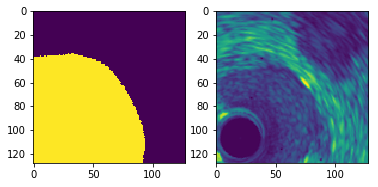

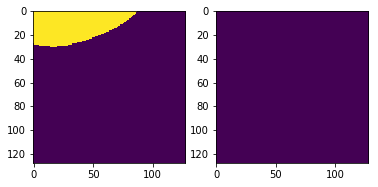

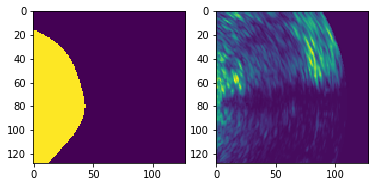

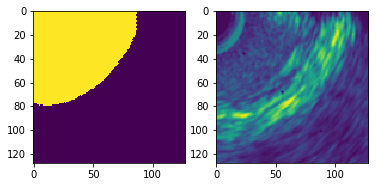

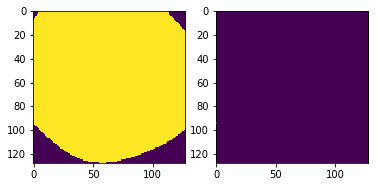

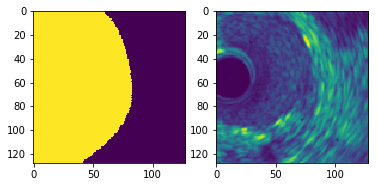

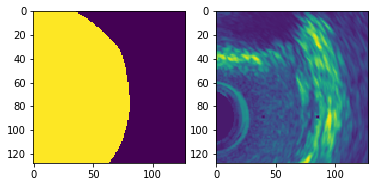

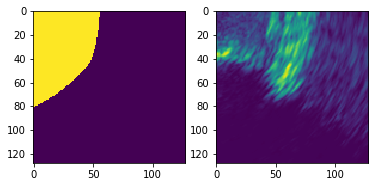

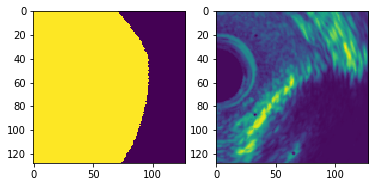

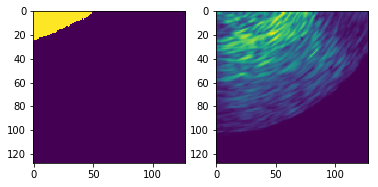

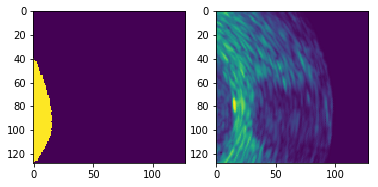

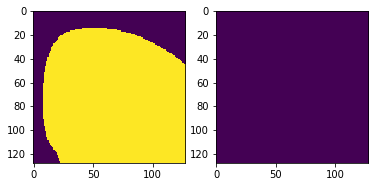

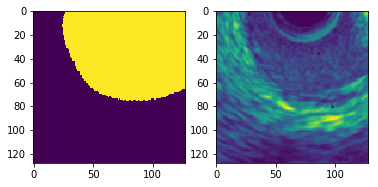

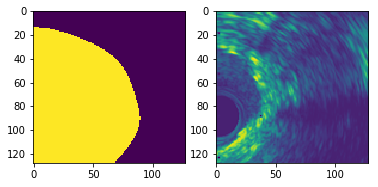

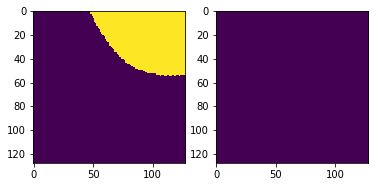

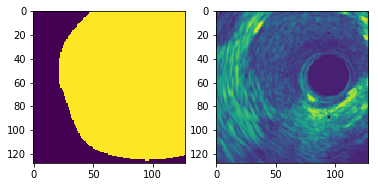

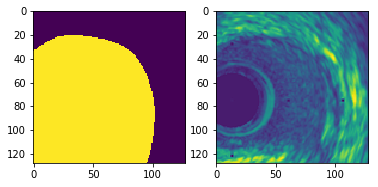

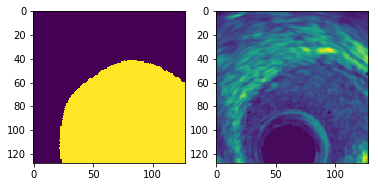

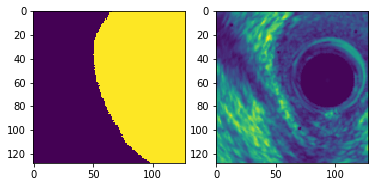

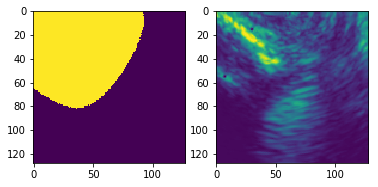

In [8]:
for i in range(20):
    plt.figure()
    plt.subplot(121)
    corrected_y = final_y[i]
    corrected_y[0] = 0
    plt.imshow(corrected_y)
    plt.subplot(122)
    plt.imshow(final_x[i])
    time.sleep(0.1)